In [1]:
import os
import geopandas as gpd
import subprocess
import re
import numpy as np
import rioxarray as rxr
import rasterio as rio
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
from shapely import geometry
from shapely import affinity
from pyproj import transform, Proj
import leafmap
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pickle

In [2]:
tif_dir = "data/Photos"
geotif_dir = "data/geotif"
os.makedirs(geotif_dir, exist_ok= True)
use_cache = False

In [3]:
def get_exif(file_path):
    exif = {}
    lat, lon, yaw, alt = subprocess.run(['exiftool', '-GPSLatitude', '-GPSLongitude', '-GimbalYawDegree', '-RelativeAltitude', file_path], stdout=subprocess.PIPE).stdout.decode("utf-8").splitlines()
    lat = lat.split(":",1)[1].strip()
    lat = [x.strip() for x in re.split('[deg\'"]', lat) if x]
    lat = dms2dec(lat)
    exif['lat'] = lat
    lon = lon.split(":",1)[1].strip()
    lon = [x.strip() for x in re.split('[deg\'"]', lon) if x]
    lon = dms2dec(lon)
    exif['lon'] = lon
    yaw = yaw.split(":",1)[1].strip()
    exif['yaw'] = float(yaw)
    alt = alt.split(":",1)[1].strip()
    exif['alt'] = float(alt)
    return exif
def dms2dec(dms):
    d = float(dms[0])
    m = float(dms[1])
    s = float(dms[2])
    return (d+m/60+s/3600)*(-1 if dms[3] in ['W', 'S'] else 1)
def img2raster(in_file, out_file, geom, crs):
    arr = np.array(Image.open(in_file))
    tl = GroundControlPoint(0, 0, geom.exterior.coords[3][0], geom.exterior.coords[3][1])
    tr = GroundControlPoint(0, arr.shape[1], geom.exterior.coords[2][0], geom.exterior.coords[2][1])
    br = GroundControlPoint(arr.shape[0], arr.shape[1], geom.exterior.coords[1][0], geom.exterior.coords[1][1])
    bl = GroundControlPoint(arr.shape[0], 0, geom.exterior.coords[0][0], geom.exterior.coords[0][1])
    gcps = [tl, bl, br, tr]
    trans = from_gcps(gcps)
    raster = rio.open(out_file, 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype),
                            crs=crs,
                            transform=trans)
    raster.write(arr, 1)
    raster.close()
def remove_outliers(raster):
    src_std = raster.std(dim=['x', 'y']).item()
    src_mean = raster.mean(dim=['x', 'y']).item()
    return raster.where(~((raster < src_mean - 3*src_std) | (raster > src_mean + 3*src_std)))

In [4]:
names = sorted([name for name in os.listdir(tif_dir) if name.endswith(".tiff")])

In [5]:
if use_cache:
    polygons = pickle.load(open("polygons.pkl", "rb"))
else:
    print("Georeferencing photos...")
    dfov_d = 40 #degrees
    hcoef = 640/819.5999023914046
    vcoef = 512/819.5999023914046
    polygons = gpd.GeoDataFrame(columns=["name", "geometry"])
    for name in tqdm(names):
        exif = get_exif(f"{tif_dir}/{name}")
        dfov_m = 2*exif['alt']*np.tan(dfov_d/2*np.pi/180)
        vfov_m = vcoef*dfov_m
        hfov_m = hcoef*dfov_m
        x, y = transform(Proj(init='epsg:4326'), Proj(init='epsg:32634'), exif['lon'], exif['lat'])
        polygon = geometry.Polygon([(x-hfov_m/2, y-vfov_m/2), (x+hfov_m/2, y-vfov_m/2), (x+hfov_m/2, y+vfov_m/2), (x-hfov_m/2, y+vfov_m/2)])
        polygon = affinity.rotate(polygon,-exif['yaw'], origin="centroid")
        polygons = polygons.append({"name": name, "geometry": polygon}, ignore_index=True)
        img2raster(f"{tif_dir}/{name}", f"{geotif_dir}/{name}", polygon, 'epsg:32634')
    polygons = polygons.set_crs('epsg:32634')

    print("Detecting intersections...")
    inters = []
    for id_i, row_i in tqdm(polygons.iterrows()):
        inter = []
        for id_j, row_j in polygons.iterrows():
            if id_i == id_j:
                continue
            if row_i['geometry'].intersects(row_j['geometry']):
                inter.append({"id": id_j,"area": row_i['geometry'].intersection(row_j['geometry']).area})
        inter = sorted(inter, key=lambda k: k['area'], reverse=True)
        inters.append(inter)
    polygons['intersect'] = inters
    
    pickle.dump(polygons, open("data/polygons.pkl", "wb"))

Georeferencing photos...


100% 466/466 [00:59<00:00,  7.84it/s]


Detecting intersections...


466it [00:13, 33.32it/s]


Calibrating pairs...
-0.418862909078598
-0.4143402874469757


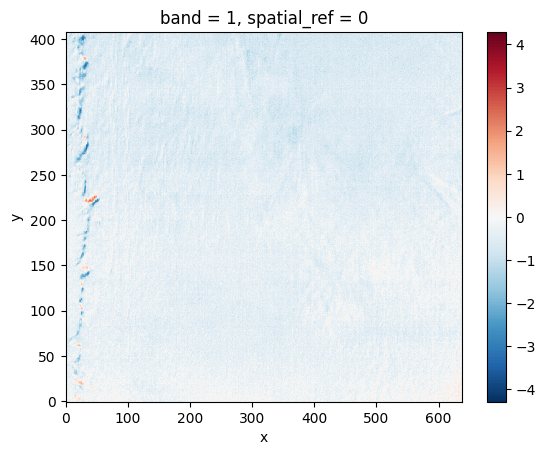

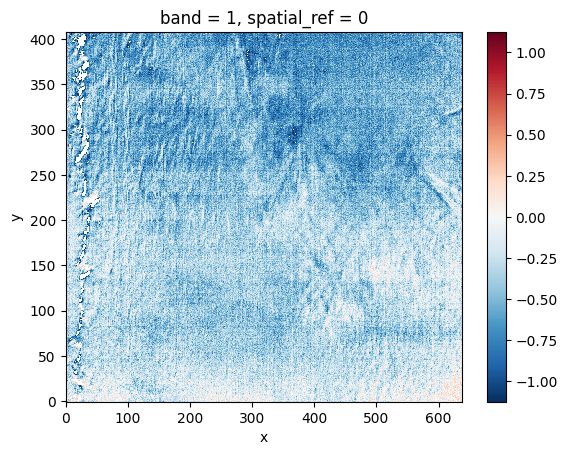

In [6]:
print("Calibrating pairs...")
src = polygons.iloc[10]
dst = polygons.iloc[src['intersect'][0]['id']]

src_raster = rxr.open_rasterio(f"{geotif_dir}/{src['name']}", masked=True).rio.clip([dst['geometry']])

dst_raster = rxr.open_rasterio(f"{geotif_dir}/{dst['name']}", masked=True).rio.clip([src['geometry']])

delta = src_raster - dst_raster
delta_masked = remove_outliers(delta)

print(delta.mean().item())
print(delta_masked.mean().item())
delta.plot()
plt.show()
delta_masked.plot()
plt.show()
# src_hist = np.histogram(rxr.open_rasterio(f"{geotif_dir}/{src['name']}", masked=True).rio.clip([dst['geometry']]), bins=50)
# dst_hist = np.histogram(rxr.open_rasterio(f"{geotif_dir}/{dst['name']}", masked=True).rio.clip([src['geometry']]), bins=50)
# plt.hist(src_hist[1][:-1], src_hist[1][1:], weights=src_hist[0], label='src')
# plt.show()
# plt.hist(dst_hist[1][:-1], dst_hist[1][1:], weights=dst_hist[0], label='dst')
# plt.show()

In [7]:
m = leafmap.Map()
m.add_raster("data/ortho.tif", layer_name='bg')
for i in polygons.iloc[0]['intersect']["id"]:
    m.add_raster(f"{geotif_dir}/{polygons.iloc[i]['name']}", layer_name=polygons.iloc[i]['name'])
m

TypeError: list indices must be integers or slices, not str